<a href="https://colab.research.google.com/github/yomyaykya/yomyay/blob/master/Fingerprint1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#!pip install --upgrade Pillow

In [2]:
import cv2
import matplotlib.pyplot as plt
%matplotlib inline
from skimage.filters import threshold_otsu
import numpy as np
from glob import glob
import scipy.misc
from matplotlib.patches import Circle,Ellipse
from matplotlib.patches import Rectangle
import os
from PIL import Image
import keras
from matplotlib import pyplot as plt
import numpy as np
import gzip
%matplotlib inline
from keras.layers import Input,Conv2D,MaxPooling2D,UpSampling2D
from keras.models import Model
from tensorflow.keras.optimizers import RMSprop
from keras.layers.normalization import layer_normalization

for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

In [3]:
import imageio
data = glob('/content/drive/MyDrive/For thesis/fingerprints/DB*/*')
images = []
from matplotlib.pyplot import imread

def readImages(data):
    for i in range(len(data)):
        img = cv2.imread(data[i])
        img = cv2.resize(img,(224,224))
        images.append(img)
        
    return images

images = readImages(data)

In [4]:
images_arr = np.asarray(images)
images_arr = images_arr.astype('float32')
images_arr.shape

(320, 224, 224, 3)

In [5]:
print("Dataset (images) shape: {shape}".format(shape=images_arr.shape))

Dataset (images) shape: (320, 224, 224, 3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Display random images in training data


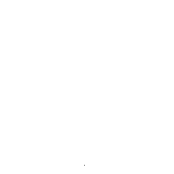

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


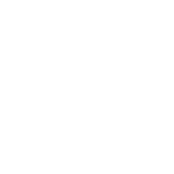

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


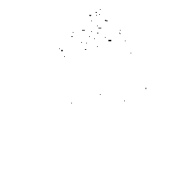

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


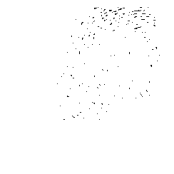

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


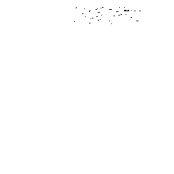

'\nx = "/content/drive/MyDrive/For thesis/fingerprints/DB1_B/"\ndef plotImages(title,directory):\n    print(title)\n    plt.figure(figsize = (12,12))\n    for i in range(25):\n        plt.subplot(5, 5, i+1)\n        img = cv2.imread( directory+ "/" + x[i])\n        plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB)); plt.axis(\'off\')\n        plt.tight_layout()\n    plt.show()\n        \nplotImages("Images of malaria infected cells","/content/drive/MyDrive/For thesis/fingerprints/DB1_B/") '

In [6]:
# Display random images in training data
print("Display random images in training data")
for i in range(20,25):
    plt.figure(figsize = (12,12))
    plt.subplot(5, 5, i+1)
    plt.imshow(cv2.cvtColor(images_arr[i], cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.tight_layout()
    plt.show()
"""
x = "/content/drive/MyDrive/For thesis/fingerprints/DB1_B/"
def plotImages(title,directory):
    print(title)
    plt.figure(figsize = (12,12))
    for i in range(25):
        plt.subplot(5, 5, i+1)
        img = cv2.imread( directory+ "/" + x[i])
        plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB)); plt.axis('off')
        plt.tight_layout()
    plt.show()
        
plotImages("Images of malaria infected cells","/content/drive/MyDrive/For thesis/fingerprints/DB1_B/") """

In [7]:
images_arr = images_arr.reshape(-1, 224,224, 1)
images_arr.shape

(960, 224, 224, 1)

In [8]:
images_arr.dtype

dtype('float32')

In [9]:
np.max(images_arr)
images_arr = images_arr / np.max(images_arr)

In [10]:
np.max(images_arr), np.min(images_arr)

(1.0, 0.0)

In [11]:
from sklearn.model_selection import train_test_split
train_X,valid_X,train_ground,valid_ground = train_test_split(images_arr,images_arr,test_size=0.2,random_state=13)

In [12]:
batch_size = 128
epochs = 300
x, y = 224, 224
input_img = Input(shape = (x, y, 1))

In [13]:
def autoencoder(input_img):
    #encoder
    #input = 28 x 28 x 1 (wide and thin)
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(input_img) #28 x 28 x 32
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1) #14 x 14 x 32
    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(pool1) #14 x 14 x 64
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2) #7 x 7 x 64
    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool2) #7 x 7 x 128 (small and thick)

    #decoder
    conv4 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv3) #7 x 7 x 128
    up1 = UpSampling2D((2,2))(conv4) # 14 x 14 x 128
    conv5 = Conv2D(64, (3, 3), activation='relu', padding='same')(up1) # 14 x 14 x 64
    up2 = UpSampling2D((2,2))(conv5) # 28 x 28 x 64
    decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(up2) # 28 x 28 x 1
    return decoded

autoencoder = Model(input_img, autoencoder(input_img))

In [14]:
autoencoder.compile(loss='mean_squared_error', optimizer = RMSprop())

In [15]:
autoencoder.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 1)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 224, 224, 32)      320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 112, 112, 32)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 112, 112, 64)      18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 56, 56, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 56, 56, 128)       73856     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 56, 56, 128)       147584